In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.beh_functions import get_session_tbl
import numpy as np
from scipy import stats
%matplotlib inline

In [653]:
file_name = '/root/capsule/data/all_tongue_movements_16092025/all_tongue_movements_16092025.parquet'
# Load the file
all_lick_df = pd.read_parquet(file_name)

In [164]:
all_lick_df['session'].unique()

array(['behavior_716325_2024-05-31_10-31-14',
       'behavior_717121_2024-06-15_10-00-58',
       'behavior_751004_2024-12-20_13-26-11',
       'behavior_751004_2024-12-21_13-28-28',
       'behavior_751004_2024-12-22_13-09-17',
       'behavior_751004_2024-12-23_14-20-03'], dtype=object)

In [654]:
sessions = all_lick_df['session'].unique()[2:]
print(sessions)


['behavior_751004_2024-12-20_13-26-11'
 'behavior_751004_2024-12-21_13-28-28'
 'behavior_751004_2024-12-22_13-09-17'
 'behavior_751004_2024-12-23_14-20-03']


In [681]:
session_licks_df = pd.DataFrame()
session_tbl = pd.DataFrame()
session_licks_trial = pd.DataFrame(columns=[
    'session','trials_ind', 'goCue_start_time', 'lick_movement_times',
    'detected_lick_ind', 'lick_registration_time', 'lick_max_x', 'lick_max_y', 'lick_max_speed'
])
for session in sessions:
    print(session)
    session_licks_df_curr = all_lick_df[all_lick_df['session']==session].reset_index(drop=True).copy()
    session_tbl_curr = get_session_tbl(session)
    session_licks_df_curr['start_time'] = session_licks_df_curr['start_time'] + session_tbl_curr['goCue_start_time'].values[0]
    session_licks_df_curr['goCue_start_time_in_session'] = session_licks_df_curr['goCue_start_time_in_session'] + session_tbl_curr['goCue_start_time'].values[0]
    session_licks_df_curr['end_time'] = session_licks_df_curr['end_time'] + session_tbl_curr['goCue_start_time'].values[0]
    session_licks_df_curr['session'] = session

    for trial_ind in range(session_tbl_curr.shape[0]):
        goCue_start_time = session_tbl_curr.loc[trial_ind, 'goCue_start_time']

        # compute lick registration time
        if session_tbl_curr.loc[trial_ind, 'animal_response'] != 2:
            lick_registration_time = session_tbl_curr.loc[trial_ind, 'reward_outcome_time']
        else:
            lick_registration_time = np.nan

        # find licks within 2s window after go cue
        lick_movement_times = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'start_time'
        ].values
        lick_max_x = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'max_x'
        ].values
        lick_max_speed = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'peak_velocity'
        ].values
        lick_max_y = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'max_y_from_jaw'
        ].values
        lick_max_x = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'max_x_from_jaw'
        ].values
        # find detected lick index if close enough
        if lick_movement_times.size > 0 and not np.isnan(lick_registration_time):
            diffs = np.abs(lick_movement_times - lick_registration_time)
            min_diff = np.min(diffs)
            detected_lick_ind = int(np.argmin(diffs)) if min_diff < 0.1 else np.nan
        else:
            detected_lick_ind = np.nan

        # append row — note: wrap lick_movement_times in a list to keep as array in one cell
        session_licks_trial = pd.concat([
            session_licks_trial,
            pd.DataFrame([{
                'session': session,
                'trials_ind': trial_ind,
                'goCue_start_time': goCue_start_time,
                'lick_movement_times': lick_movement_times,  # stored as np.ndarray in one cell
                'detected_lick_ind': detected_lick_ind,
                'lick_registration_time': lick_registration_time,
                'lick_max_x': lick_max_x,
                'lick_max_y': lick_max_y,
                'lick_max_speed': lick_max_speed
            }])
        ], ignore_index=True)
    session_licks_df = pd.concat([session_licks_df, session_licks_df_curr], ignore_index=True)
    session_tbl = pd.concat([session_tbl, session_tbl_curr], ignore_index=True)

# compute and subtract center line for each session
for session in sessions:
    session_licks_trial_curr = session_licks_trial[session_licks_trial['session']==session].reset_index(drop=True)
    session_tbl_curr = get_session_tbl(session)
    first_lick_y = [max_ys[0] if len(max_ys)>0 else np.nan for max_ys in session_licks_trial_curr['lick_max_y'].values]
    first_lick_y = np.array(first_lick_y)
    mode_left = np.mean(first_lick_y[session_tbl_curr['animal_response'].values==0])
    mode_right = np.mean(first_lick_y[session_tbl_curr['animal_response'].values==1])
    center_line = (mode_left + mode_right) / 2
    max_x = session_licks_df.loc[session_licks_df['session']==session, 'max_x'].mean()
    session_licks_df.loc[session_licks_df['session']==session, 'max_y_centered'] = session_licks_df.loc[session_licks_df['session']==session, 'max_y'] - center_line
    session_licks_df.loc[session_licks_df['session']==session, 'max_y_from_jaw_centered'] = session_licks_df.loc[session_licks_df['session']==session, 'max_y_from_jaw'] - center_line
    session_licks_df.loc[session_licks_df['session']==session, 'max_x_centered'] = session_licks_df.loc[session_licks_df['session']==session, 'max_x'] - max_x
    session_licks_df.loc[session_licks_df['session']==session, 'max_x_from_jaw_centered'] = session_licks_df.loc[session_licks_df['session']==session, 'max_x_from_jaw'] - max_x

    

behavior_751004_2024-12-20_13-26-11


/tmp/ipykernel_1054477/2988987077.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  session_licks_trial = pd.concat([


behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-22_13-09-17
behavior_751004_2024-12-23_14-20-03


In [757]:
session_licks_trial = pd.DataFrame(columns=[
    'session','trials_ind', 'goCue_start_time', 'lick_movement_times',
    'detected_lick_ind', 'lick_registration_time', 'lick_max_x', 'lick_max_y', 'lick_max_speed'
])
for session in sessions:
    print(session)
    session_licks_df_curr = session_licks_df[session_licks_df['session']==session].reset_index(drop=True).copy()
    session_tbl_curr = get_session_tbl(session)

    for trial_ind in range(session_tbl_curr.shape[0]):
        goCue_start_time = session_tbl_curr.loc[trial_ind, 'goCue_start_time']

        # compute lick registration time
        if session_tbl_curr.loc[trial_ind, 'animal_response'] != 2:
            lick_registration_time = session_tbl_curr.loc[trial_ind, 'reward_outcome_time']-goCue_start_time
        else:
            lick_registration_time = np.nan

        # find licks within 2s window after go cue
        lick_movement_times = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'start_time'
        ].values - goCue_start_time
        lick_max_x = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'max_x_centered'
        ].values
        lick_max_speed = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'peak_velocity'
        ].values
        lick_max_y = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'max_y_from_jaw_centered'
        ].values
        lick_max_x = session_licks_df_curr.loc[
            (session_licks_df_curr['start_time'] >= goCue_start_time) &
            (session_licks_df_curr['start_time'] <= goCue_start_time + 2),
            'max_x_from_jaw_centered'
        ].values
        # find detected lick index if close enough
        if lick_movement_times.size > 0 and not np.isnan(lick_registration_time):
            diffs = np.abs(lick_movement_times - lick_registration_time)
            min_diff = np.min(diffs)
            detected_lick_ind = int(np.argmin(diffs)) if min_diff < 0.1 else np.nan
        else:
            detected_lick_ind = np.nan

        # append row — note: wrap lick_movement_times in a list to keep as array in one cell
        session_licks_trial = pd.concat([
            session_licks_trial,
            pd.DataFrame([{
                'session': session,
                'trials_ind': trial_ind,
                'goCue_start_time': goCue_start_time,
                'rwd': session_tbl_curr['rewarded_historyL'][trial_ind] | session_tbl_curr['rewarded_historyR'][trial_ind],
                'first_lick_sign': np.sign(lick_max_y[0]) if len(lick_max_y)>0 else np.nan,
                'lick_movement_times': lick_movement_times,  # stored as np.ndarray in one cell
                'detected_lick_ind': detected_lick_ind,
                'lick_registration_time': lick_registration_time,
                'lick_max_x': lick_max_x,
                'lick_max_y': lick_max_y,
                'lick_max_speed': lick_max_speed
            }])
        ], ignore_index=True)

behavior_751004_2024-12-20_13-26-11


/tmp/ipykernel_1054477/2162771520.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  session_licks_trial = pd.concat([


behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-22_13-09-17
behavior_751004_2024-12-23_14-20-03


(array([   0., 1164.,    0.,  680.,    0.,  124.,    0.,   24.,    0.,
           2.]),
 array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <BarContainer object of 10 artists>)

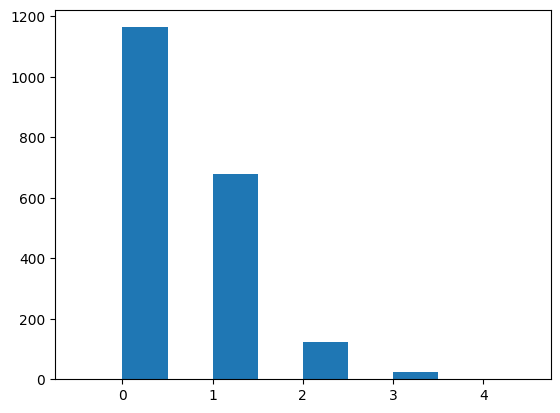

In [727]:
plt.hist(session_licks_trial['detected_lick_ind'].dropna(), bins=np.arange(-0.5, 5, 0.5))

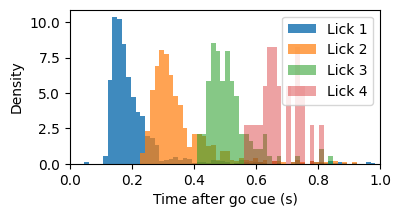

In [801]:
fig = plt.figure(figsize=(4, 2))
bins = np.linspace(0, 1.5, 100)
for lick_ind in range(session_licks_trial['detected_lick_ind'].max()):
    if np.sum(session_licks_trial['detected_lick_ind'] == lick_ind) < 5:
        continue
    lick_times = session_licks_trial.loc[
        session_licks_trial['detected_lick_ind'] == lick_ind, 'lick_registration_time'
    ].values
    plt.hist(lick_times, bins=bins, alpha=1-1/(session_licks_trial['detected_lick_ind'].max()+2)*(lick_ind+1), label=f'Lick {lick_ind+1}', density=True)
plt.xlabel('Time after go cue (s)')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.legend()


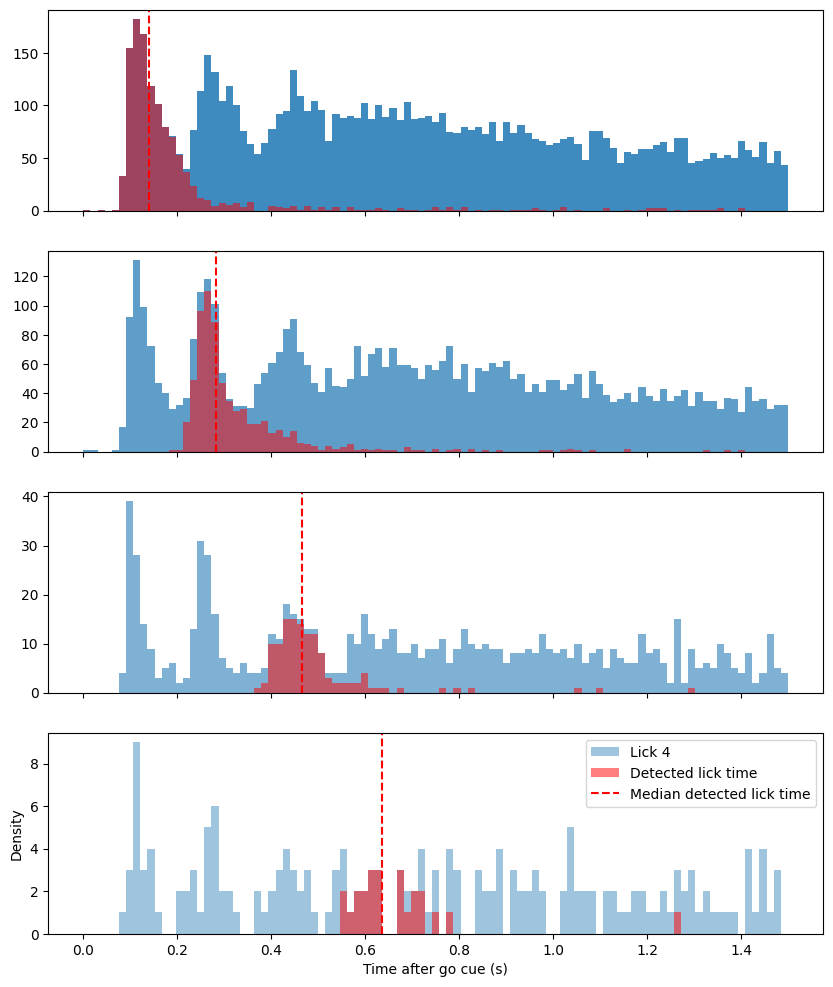

In [803]:
bins = np.linspace(0, 1.5, 100)
fig, axes = plt.subplots(session_licks_trial['detected_lick_ind'].max()-1, 1, figsize=(5, 6), sharex=True)
for lick_ind in range(session_licks_trial['detected_lick_ind'].max()-1):
    ax = axes[lick_ind]
    if np.sum(session_licks_trial['detected_lick_ind'] == lick_ind) < 5:
        continue
    lick_times = session_licks_trial.loc[
        session_licks_trial['detected_lick_ind'] == lick_ind, 'lick_movement_times'
    ].values
    # combine all lick times into one array
    lick_detection_time = [lick_times_curr[lick_ind] for lick_times_curr in lick_times]
    lick_times = np.concatenate(lick_times)
    ax.hist(lick_times, bins=bins, alpha=1-1/(session_licks_trial['detected_lick_ind'].max()+2)*(lick_ind+1), label=f'Lick {lick_ind+1}')
    ax.hist(lick_detection_time, bins=bins, color='r', alpha=0.5, label='Detected lick time')
    ax.axvline(np.median(lick_detection_time), color='r', linestyle='--', label='Median detected lick time')
plt.xlabel('Time after go cue (s)')
plt.ylabel('Density')
plt.legend()

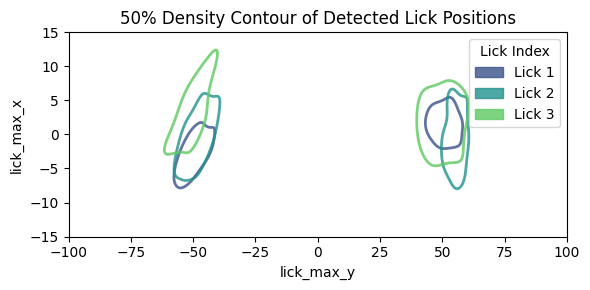

In [756]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
colors = sns.color_palette("viridis", n_colors=3)

for lick_ind in range(3):
    mask = session_licks_trial['detected_lick_ind'] == lick_ind
    if np.sum(mask) < 5:
        continue

    lick_max_y = session_licks_trial.loc[mask, 'lick_max_y'].values
    lick_max_y = np.array([
        max_ys[lick_ind] if len(max_ys) > lick_ind else np.nan
        for max_ys in lick_max_y
    ])
    lick_max_x = session_licks_trial.loc[mask, 'lick_max_x'].values
    lick_max_x = np.array([
        max_xs[lick_ind] if len(max_xs) > lick_ind else np.nan
        for max_xs in lick_max_x
    ])

    valid = ~np.isnan(lick_max_x) & ~np.isnan(lick_max_y)
    if np.sum(valid) < 5 or len(np.unique(lick_max_x[valid])) < 3:
        continue

    # plot only 50% contour (no fill) # separate negative or positive ones
    left_filter = lick_max_y[valid] > 0
    if np.sum(left_filter) > 5:
        sns.kdeplot(
            x=lick_max_y[valid][left_filter],
            y=lick_max_x[valid][left_filter],
            fill=False,
            levels=[0.5],
            color=colors[lick_ind],
            linewidths=2,
            alpha=0.8,
            ax=ax,
        )
    right_filter = lick_max_y[valid] < 0
    if np.sum(right_filter) > 5:
        sns.kdeplot(
            x=lick_max_y[valid][right_filter],
            y=lick_max_x[valid][right_filter],
            fill=False,
            levels=[0.5],
            color=colors[lick_ind],
            linewidths=2,
            alpha=0.8,
            ax=ax,
        )
    
    # sns.kdeplot(
    #     x=lick_max_y[valid],
    #     y=lick_max_x[valid],
    #     fill=False,
    #     levels=[0.5],
    #     color=colors[lick_ind],
    #     linewidths=2,
    #     alpha=0.8,
    #     ax=ax,
    # )

# --- Manually add legend patches ---
patches = [
    mpatches.Patch(color=colors[i], label=f"Lick {i+1}", alpha=0.8)
    for i in range(3)
]
ax.legend(handles=patches, title="Lick Index", loc="best", frameon=True)

# --- Axes settings ---
ax.set_xlim(-100, 100)
ax.set_ylim(-15, 15)
ax.set_title("50% Density Contour of Detected Lick Positions")
ax.set_xlabel("lick_max_y")
ax.set_ylabel("lick_max_x")

plt.tight_layout()
plt.show()


In [794]:
# flatten session_licks_trial so each lick is its own row

rows_flat = []  # collect all rows first (faster than concat in loop)
for idx, row in session_licks_trial.iterrows():
    lick_times = row['lick_movement_times']
    lick_max_xs = row['lick_max_x']
    lick_max_ys = row['lick_max_y']
    lick_max_speeds = row['lick_max_speed']

    # ensure they’re iterable
    if lick_times is None or len(lick_times) == 0:
        continue

    for lick_ind, lick_time in enumerate(lick_times):
        # safely extract matching features
        lick_max_x = lick_max_xs[lick_ind]
        lick_max_y = lick_max_ys[lick_ind]
        lick_max_speed = lick_max_speeds[lick_ind]

        rows_flat.append({
            'session': row.get('session', np.nan),
            'trials_ind': row['trials_ind'],
            'goCue_start_time': row['goCue_start_time'],
            'lick_time': lick_time,
            'rwd': row['rwd'],
            'detected_lick_ind': row['detected_lick_ind'],
            'lick_registration_time': row['lick_registration_time'],
            'lick_max_x': lick_max_x,
            'lick_max_y': lick_max_y,
            'lick_max_speed': lick_max_speed,
            'lick_counts': lick_ind,
            'first_lick_sign': row['first_lick_sign'],
            'first_lick_y': lick_max_ys[0] if len(lick_max_ys)>0 else np.nan,
            'first_lick_x': lick_max_xs[0] if len(lick_max_xs)>0 else np.nan,
            'previous_lick_y': lick_max_ys[lick_ind-1] if lick_ind>0 and len(lick_max_ys)>lick_ind-1 else np.nan,
            'previous_lick_x': lick_max_xs[lick_ind-1] if lick_ind>0 and len(lick_max_xs)>lick_ind-1 else np.nan,
        })

# build final DataFrame
session_licks_trial_flat = pd.DataFrame(rows_flat)


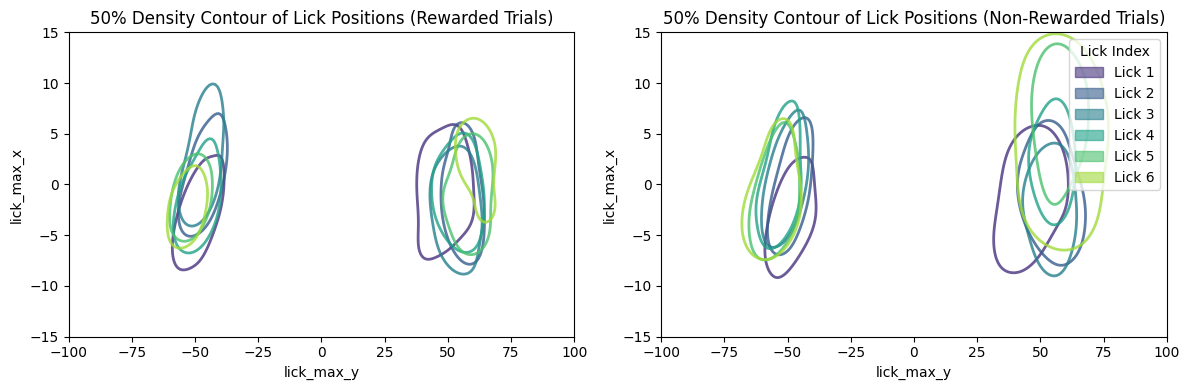

In [761]:
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_lick_counts = 6
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
colors = sns.color_palette("viridis", n_colors=all_lick_counts)

# ---------------------------------------
# Left subplot: Rewarded trials
# ---------------------------------------
ax = axes[0]
for lick_ind in range(all_lick_counts):
    mask = (session_licks_trial_flat['lick_counts'] == lick_ind) & (session_licks_trial_flat['rwd'])
    if np.sum(mask) < 5:
        continue

    lick_max_y = session_licks_trial_flat.loc[mask, 'lick_max_y'].values
    lick_max_x = session_licks_trial_flat.loc[mask, 'lick_max_x'].values
    first_side = session_licks_trial_flat.loc[mask, 'first_lick_sign'].values

    valid = ~np.isnan(lick_max_x) & ~np.isnan(lick_max_y)
    if np.sum(valid) < 5 or len(np.unique(lick_max_x[valid])) < 3:
        continue

    # separate left and right
    left_filter = first_side[valid] > 0
    if np.sum(left_filter) > 5:
        sns.kdeplot(
            x=lick_max_y[valid][left_filter],
            y=lick_max_x[valid][left_filter],
            fill=False,           # ← only contour, no fill
            levels=[0.5],         # ← 50% density line
            color=colors[lick_ind],
            linewidths=2,
            alpha=0.8,
            ax=ax,
        )
    right_filter = first_side[valid] < 0
    if np.sum(right_filter) > 5:
        sns.kdeplot(
            x=lick_max_y[valid][right_filter],
            y=lick_max_x[valid][right_filter],
            fill=False,           # ← only contour, no fill
            levels=[0.5],         # ← 50% density line
            color=colors[lick_ind],
            linewidths=2,
            alpha=0.8,
            ax=ax,
        )

    # sns.kdeplot(
    #     x=lick_max_y[valid],
    #     y=lick_max_x[valid],
    #     fill=False,           # ← only contour, no fill
    #     levels=[0.5],         # ← 50% density line
    #     color=colors[lick_ind],
    #     linewidths=2,
    #     alpha=0.8,
    #     ax=ax,
    # )

# legend and titles for rewarded
patches = [mpatches.Patch(color=colors[i], label=f'Lick {i+1}', alpha=0.6) for i in range(all_lick_counts)]
# ax.legend(handles=patches, title="Lick Index", loc="best")
ax.set_title("50% Density Contour of Lick Positions (Rewarded Trials)")
ax.set_xlabel("lick_max_y")
ax.set_ylabel("lick_max_x")
ax.set_xlim(-100, 100)
ax.set_ylim(-15, 15)


# ---------------------------------------
# Right subplot: Non-Rewarded trials
# ---------------------------------------
ax = axes[1]
for lick_ind in range(all_lick_counts):
    mask = (session_licks_trial_flat['lick_counts'] == lick_ind) & (~session_licks_trial_flat['rwd'])
    if np.sum(mask) < 5:
        continue

    lick_max_y = session_licks_trial_flat.loc[mask, 'lick_max_y'].values
    lick_max_x = session_licks_trial_flat.loc[mask, 'lick_max_x'].values
    first_side = session_licks_trial_flat.loc[mask, 'first_lick_sign'].values

    valid = ~np.isnan(lick_max_x) & ~np.isnan(lick_max_y)
    if np.sum(valid) < 5 or len(np.unique(lick_max_x[valid])) < 3:
        continue

    # separate left and right
    left_filter = first_side[valid] > 0
    if np.sum(left_filter) > 5:
        sns.kdeplot(
            x=lick_max_y[valid][left_filter],
            y=lick_max_x[valid][left_filter],
            fill=False,           # ← contour only
            levels=[0.5],
            color=colors[lick_ind],
            linewidths=2,
            alpha=0.8,
            ax=ax,
        )
    right_filter = first_side[valid] < 0
    if np.sum(right_filter) > 5:
        sns.kdeplot(
            x=lick_max_y[valid][right_filter],
            y=lick_max_x[valid][right_filter],
            fill=False,           # ← contour only
            levels=[0.5],
            color=colors[lick_ind],
            linewidths=2,
            alpha=0.8,
            ax=ax,
        )

    # sns.kdeplot(
    #     x=lick_max_y[valid],
    #     y=lick_max_x[valid],
    #     fill=False,           # ← contour only
    #     levels=[0.5],
    #     color=colors[lick_ind],
    #     linewidths=2,
    #     alpha=0.8,
    #     ax=ax,
    # )

# legend and titles for non-rewarded
patches = [mpatches.Patch(color=colors[i], label=f'Lick {i+1}', alpha=0.6) for i in range(all_lick_counts)]
ax.legend(handles=patches, title="Lick Index", loc="best")
ax.set_title("50% Density Contour of Lick Positions (Non-Rewarded Trials)")
ax.set_xlabel("lick_max_y")
ax.set_ylabel("lick_max_x")
ax.set_xlim(-100, 100)
ax.set_ylim(-15, 15)

plt.tight_layout()
plt.show()


Text(0, 0.5, 'P(switch side)')

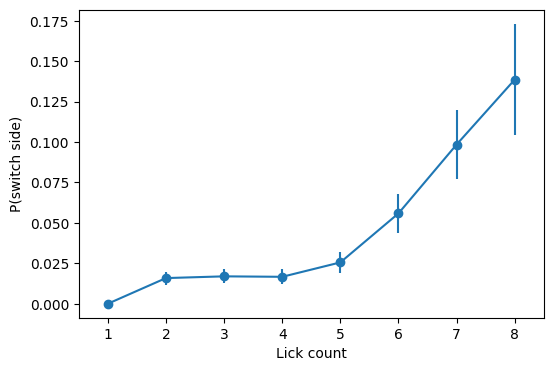

In [780]:
# in no reward trials, P(different that first lick side) as a function of lick count
max_count = 8
pSwitch = np.zeros(max_count)
pSwitch_se = np.zeros(max_count)
for lick_count_ind in range(max_count):
    mask = (session_licks_trial_flat['lick_counts'] == lick_count_ind) & (~session_licks_trial_flat['rwd'])
    if np.sum(mask) < 5:
        pSwitch[lick_count_ind-1] = np.nan
        continue

    first_sides = session_licks_trial_flat.loc[mask, 'first_lick_sign'].values
    curr_sides = np.sign(session_licks_trial_flat.loc[mask, 'lick_max_y'].values)

    valid = ~np.isnan(curr_sides) & ~np.isnan(first_sides)
    if np.sum(valid) < 5:
        pSwitch[lick_count_ind-1] = np.nan
        continue

    pSwitch[lick_count_ind] = np.mean(np.sign(curr_sides[valid]) != first_sides[valid])
    pSwitch_se[lick_count_ind] = stats.sem(np.sign(curr_sides[valid]) != first_sides[valid])
plt.figure(figsize=(6,4))
plt.errorbar(np.arange(1, max_count+1), pSwitch, pSwitch_se, fmt='-o')
plt.xlim(0.5, max_count+0.5)
plt.xlabel('Lick count')
plt.ylabel('P(switch side)')

Text(0, 0.5, 'Distance from first lick (same side only)')

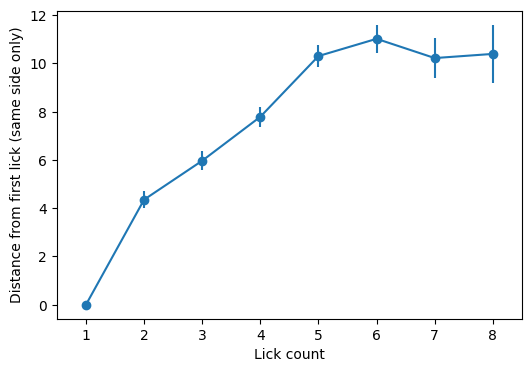

In [791]:
# for those did not switch, how much was adjusted by distance? 
max_count = 8
delta_dist = np.zeros(max_count)
delta_dist_se = np.zeros(max_count)
for lick_counts_ind in range(max_count):
    mask = (session_licks_trial_flat['lick_counts'] == lick_counts_ind) & (~session_licks_trial_flat['rwd'])
    if np.sum(mask) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    first_sides = session_licks_trial_flat.loc[mask, 'first_lick_sign'].values
    curr_sides = np.sign(session_licks_trial_flat.loc[mask, 'lick_max_y'].values)
    curr_y = session_licks_trial_flat.loc[mask, 'lick_max_y'].values

    valid = ~np.isnan(curr_sides) & ~np.isnan(first_sides) & ~np.isnan(curr_y)
    if np.sum(valid) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    same_side = curr_sides[valid] == first_sides[valid]
    if np.sum(same_side) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    # distance from center line for first lick
    first_lick_y = session_licks_trial_flat.loc[mask, 'first_lick_y'].values[valid][same_side]
    delta_dist_curr = (curr_y[valid][same_side] - first_lick_y)* first_sides[valid][same_side]
    delta_dist[lick_counts_ind] = np.mean(delta_dist_curr)
    delta_dist_se[lick_counts_ind] = stats.sem(delta_dist_curr)
plt.figure(figsize=(6,4))
plt.errorbar(np.arange(1, max_count+1), delta_dist, delta_dist_se, fmt='-o')
plt.xlim(0.5, max_count+0.5)
plt.xlabel('Lick count')
plt.ylabel('Distance from first lick (same side only)')

Text(0, 0.5, 'Distance from previous lick (same side only)_lateral')

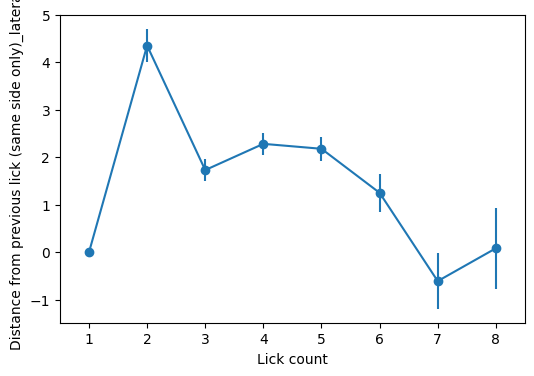

In [798]:
# in no reward trials, P(different that first lick side) as a function of lick count
max_count = 8
pSwitch = np.zeros(max_count)
pSwitch_se = np.zeros(max_count)
for lick_count_ind in range(max_count):
    mask = (session_licks_trial_flat['lick_counts'] == lick_count_ind) & (~session_licks_trial_flat['rwd'])
    if np.sum(mask) < 5:
        pSwitch[lick_count_ind-1] = np.nan
        continue

    first_sides = session_licks_trial_flat.loc[mask, 'first_lick_sign'].values
    curr_sides = np.sign(session_licks_trial_flat.loc[mask, 'lick_max_y'].values)

    valid = ~np.isnan(curr_sides) & ~np.isnan(first_sides)
    if np.sum(valid) < 5:
        pSwitch[lick_count_ind-1] = np.nan
        continue

    pSwitch[lick_count_ind] = np.mean(np.sign(curr_sides[valid]) != first_sides[valid])
    pSwitch_se[lick_count_ind] = stats.sem(np.sign(curr_sides[valid]) != first_sides[valid])
plt.figure(figsize=(6,4))
plt.errorbar(np.arange(1, max_count+1), pSwitch, pSwitch_se, fmt='-o')
plt.xlim(0.5, max_count+0.5)
plt.xlabel('Lick count')
plt.ylabel('P(switch side)')

Text(0, 0.5, 'Distance from previous lick (same side only)_ap')

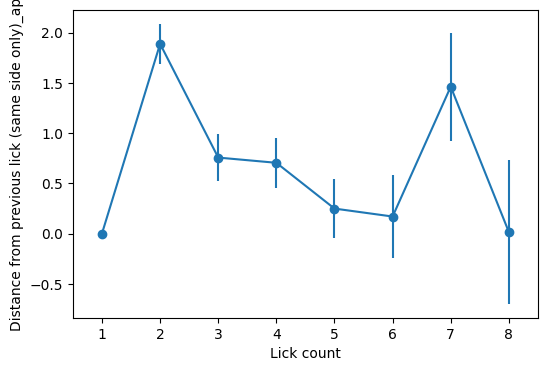

In [799]:
# for those did not switch, how much was adjusted by distance from previous lick? 
max_count = 8
delta_dist = np.zeros(max_count)
delta_dist_se = np.zeros(max_count)
for lick_counts_ind in range(max_count):
    mask = (session_licks_trial_flat['lick_counts'] == lick_counts_ind) & (~session_licks_trial_flat['rwd'])
    if np.sum(mask) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    prev_y = session_licks_trial_flat.loc[mask, 'previous_lick_y'].values
    prev_sides = np.sign(prev_y)
    prev_x = session_licks_trial_flat.loc[mask, 'previous_lick_x'].values
    curr_sides = np.sign(session_licks_trial_flat.loc[mask, 'lick_max_y'].values)
    curr_x = session_licks_trial_flat.loc[mask, 'lick_max_x'].values

    valid = ~np.isnan(curr_sides) & ~np.isnan(curr_x) & ~np.isnan(prev_y)
    if np.sum(valid) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    same_side = curr_sides[valid] == prev_sides[valid]
    if np.sum(same_side) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    # distance from center line for first lick
    pre_lick_x = session_licks_trial_flat.loc[mask, 'previous_lick_x'].values[valid][same_side]
    delta_dist_curr = (curr_x[valid][same_side] - pre_lick_x)
    delta_dist[lick_counts_ind] = np.mean(delta_dist_curr)
    delta_dist_se[lick_counts_ind] = stats.sem(delta_dist_curr)
plt.figure(figsize=(6,4))
plt.errorbar(np.arange(1, max_count+1), delta_dist, delta_dist_se, fmt='-o')
plt.xlim(0.5, max_count+0.5)
plt.xlabel('Lick count')
plt.ylabel('Distance from previous lick (same side only)_ap')

Text(0, 0.5, 'Distance from first lick (same side only)_ap')

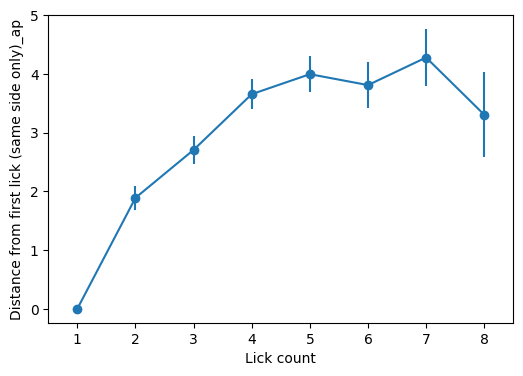

In [800]:
# for those did not switch, how much was adjusted by distance? 
max_count = 8
delta_dist = np.zeros(max_count)
delta_dist_se = np.zeros(max_count)
for lick_counts_ind in range(max_count):
    mask = (session_licks_trial_flat['lick_counts'] == lick_counts_ind) & (~session_licks_trial_flat['rwd'])
    if np.sum(mask) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    first_sides = session_licks_trial_flat.loc[mask, 'first_lick_sign'].values
    curr_sides = np.sign(session_licks_trial_flat.loc[mask, 'lick_max_y'].values)
    curr_x = session_licks_trial_flat.loc[mask, 'lick_max_x'].values

    valid = ~np.isnan(curr_sides) & ~np.isnan(first_sides) & ~np.isnan(curr_x)
    if np.sum(valid) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    same_side = curr_sides[valid] == first_sides[valid]
    if np.sum(same_side) < 5:
        delta_dist[lick_counts_ind-1] = np.nan
        continue

    # distance from center line for first lick
    first_lick_x = session_licks_trial_flat.loc[mask, 'first_lick_x'].values[valid][same_side]
    delta_dist_curr = (curr_x[valid][same_side] - first_lick_x)
    delta_dist[lick_counts_ind] = np.mean(delta_dist_curr)
    delta_dist_se[lick_counts_ind] = stats.sem(delta_dist_curr)
plt.figure(figsize=(6,4))
plt.errorbar(np.arange(1, max_count+1), delta_dist, delta_dist_se, fmt='-o')
plt.xlim(0.5, max_count+0.5)
plt.xlabel('Lick count')
plt.ylabel('Distance from first lick (same side only)_ap')

In [762]:
# concatenate all licks that happended before lick registration time into one array
all_licks_before_registration = []
all_licks_ind = []
all_licks_sides = []
for ind, row in session_licks_trial.iterrows():
    if not np.isnan(row['lick_registration_time']):
        lick_times = row['lick_movement_times']
        goCue_time = row['goCue_start_time']
        lick_max_y = row['lick_max_y']
        registration_time = row['lick_registration_time']
        
        valid_licks = lick_times[(lick_times >= goCue_time) & (lick_times <= registration_time)]
        lick_ind = range(len(valid_licks))
        lick_sides = [0 if y < center_line else 1 for y in lick_max_y   ]

        all_licks_before_registration.extend(valid_licks - goCue_time)
        all_licks_ind.extend(lick_ind)
        all_licks_sides.extend(lick_sides[:len(valid_licks)])
all_licks_before_registration = np.array(all_licks_before_registration)
all_licks_ind = np.array(all_licks_ind)
all_licks_sides = np.array(all_licks_sides)


In [763]:
# for 2nd, 3rd and 4th lick, what the probability that they switched side compared to the previous one
switch_probs = []
for lick_ind in range(1, 4):
    curr_licks = all_licks_sides[all_licks_ind == lick_ind]
    # select previous lick where current lick is preceding next one, and also lick ind == lick_ind - 1
    pre_filter = np.where((all_licks_ind[:-1] == lick_ind - 1) & (all_licks_ind[1:] == lick_ind))[0]
    prev_licks = all_licks_sides[pre_filter]
    switch_prob = np.mean(curr_licks != prev_licks)
    switch_probs.append(switch_prob)
switch_probs = np.array(switch_probs)

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [764]:
# concatenate all licks that happended after lick registration time into one array
all_licks_after_registration = []
all_licks_ind = []
all_licks_sides = []
rwds = []
for ind, row in session_licks_trial.iterrows():
    if not np.isnan(row['lick_registration_time']):
        lick_times = row['lick_movement_times']
        goCue_time = row['goCue_start_time']
        lick_max_y = row['lick_max_y']
        registration_time = row['lick_registration_time']
        lick_ind = row['detected_lick_ind']
        outcome = session_tbl.loc[row['trials_ind'], 'rewarded_historyL'] | session_tbl.loc[row['trials_ind'], 'rewarded_historyR']
        if np.isnan(lick_ind):
            continue
        valid_licks = lick_times[lick_ind:]
        lick_sides = [0 if y < center_line else 1 for y in lick_max_y   ]

        all_licks_after_registration.extend(valid_licks - goCue_time)
        all_licks_ind.extend(range(len(valid_licks)))
        all_licks_sides.extend(lick_sides[lick_ind:])
        rwds.extend([outcome]*len(valid_licks))
all_licks_after_registration = np.array(all_licks_after_registration)
all_licks_ind = np.array(all_licks_ind)
all_licks_sides = np.array(all_licks_sides)
rwds = np.array(rwds)

In [765]:
# for 2nd, 3rd and 4th lick, what the probability that they switched side compared to the previous one
switch_probs_rwd = []
for lick_ind in range(1, 4):
    curr_licks = all_licks_sides[(all_licks_ind == lick_ind) & (rwds == 1)]
    # select previous lick where current lick is preceding next one, and also lick ind == lick_ind - 1
    pre_filter = np.where((all_licks_ind[:-1] == lick_ind - 1) & (all_licks_ind[1:] == lick_ind) & (rwds[:-1] == 1))[0]
    prev_licks = all_licks_sides[pre_filter]
    switch_prob = np.mean(curr_licks != prev_licks)
    switch_probs_rwd.append(switch_prob)
switch_probs_rwd = np.array(switch_probs_rwd)

In [766]:
switch_probs_norwd = []
for lick_ind in range(1, 4):
    curr_licks = all_licks_sides[(all_licks_ind == lick_ind) & (rwds == 0)]
    # select previous lick where current lick is preceding next one, and also lick ind == lick_ind - 1
    pre_filter = np.where((all_licks_ind[:-1] == lick_ind - 1) & (all_licks_ind[1:] == lick_ind) & (rwds[:-1] == 0))[0]
    prev_licks = all_licks_sides[pre_filter]
    switch_prob = np.mean(curr_licks != prev_licks)
    switch_probs_norwd.append(switch_prob)
switch_probs_norwd = np.array(switch_probs_norwd)

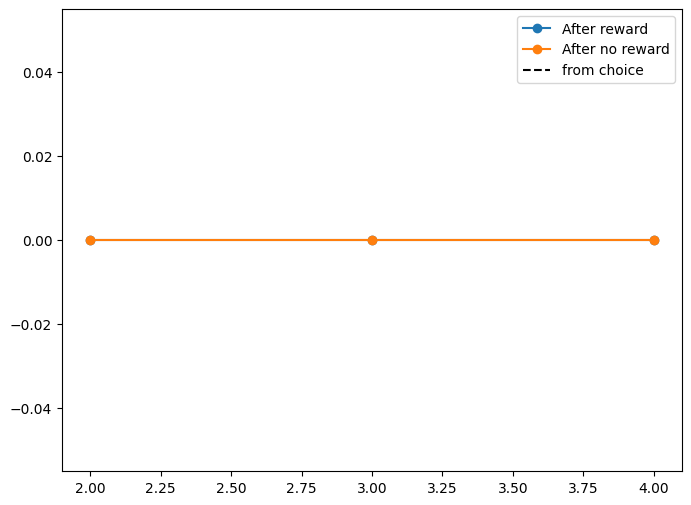

In [767]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(2, 5), switch_probs_rwd, marker='o', label='After reward')
plt.plot(range(2, 5), switch_probs_norwd, marker='o', label='After no reward')
plt.plot(range(2, 5), switch_probs, linestyle='--', color='k', label='from choice')
plt.legend()

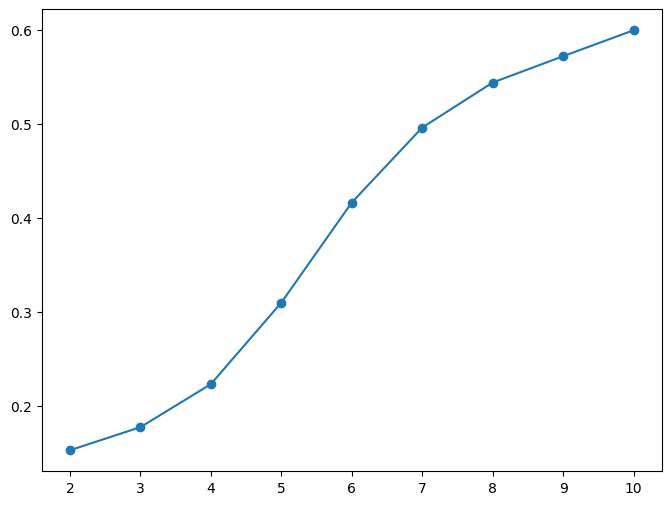

In [768]:
# focus on no reward trials, see switch prob after each lick
no_rwd_trials = session_tbl[session_tbl['rewarded_historyL'] & session_tbl['rewarded_historyR'] == 0].index.values
no_rwd_licks_mat = np.full((no_rwd_trials.shape[0], 10), np.nan)
lick_ind = session_licks_trial['detected_lick_ind'][no_rwd_trials].values
# fill in the matrix
# for each go cue, find all licks after it within 2s
for i, trial_ind in enumerate(no_rwd_trials):
    goCue_start_time = session_tbl.loc[trial_ind, 'goCue_start_time']
    lick_times = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'start_time'
    ].values
    lick_max_y = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'max_y_from_jaw'
    ].values
    lick_sides = [0 if y < center_line else 1 for y in lick_max_y   ]
    no_rwd_licks_mat[i, :len(lick_sides)] = lick_sides[:10]
# compute switch prob for each lick index
# in no_rwd_licks_mat, compute if each lick is different from the previous one
switch_probs_no_rwd = []
diff_mat = no_rwd_licks_mat[:, 1:] != no_rwd_licks_mat[:, :-1]
for ind in range(1, 10):
    curr_licks = diff_mat[:, ind - 1]
    switch_prob = np.nanmean(curr_licks)
    switch_probs_no_rwd.append(switch_prob)
switch_probs_no_rwd = np.array(switch_probs_no_rwd)
fig = plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), switch_probs_no_rwd, marker='o', label='After no reward')

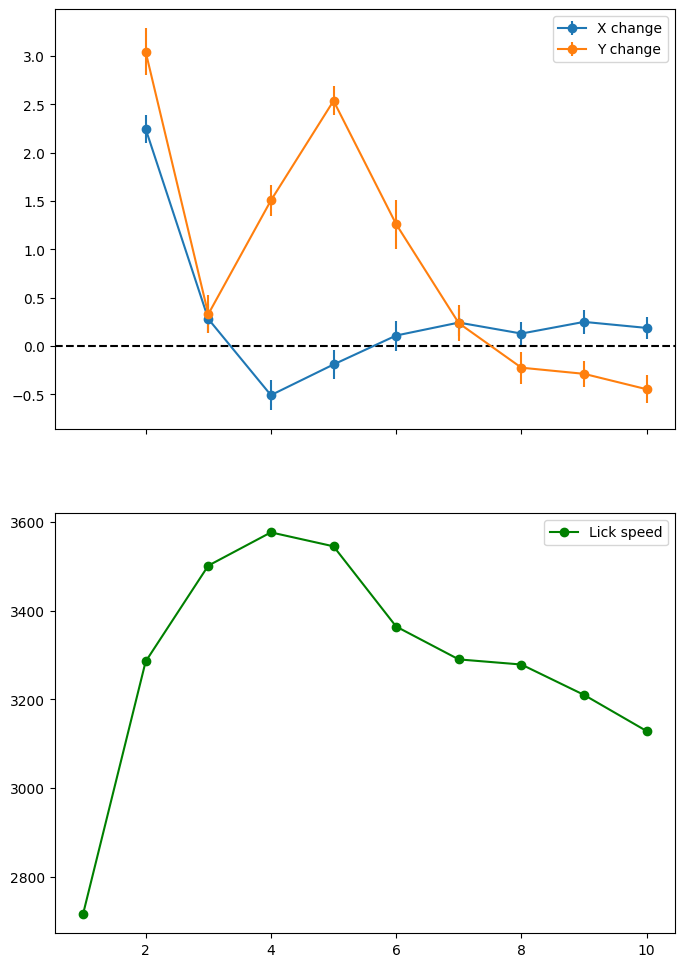

In [769]:
# see correction as location change
# focus on no reward trials, see switch prob after each lick
no_rwd_trials = session_tbl[session_tbl['rewarded_historyL'] & session_tbl['rewarded_historyR'] == 0].index.values
no_rwd_licks_x_mat = np.full((no_rwd_trials.shape[0], 10), np.nan)
no_rwd_licks_y_mat = np.full((no_rwd_trials.shape[0], 10), np.nan)
no_rwd_lick_speed_mat  = np.full((no_rwd_trials.shape[0], 10), np.nan)
lick_ind = session_licks_trial['detected_lick_ind'][no_rwd_trials].values
# fill in the matrix
# for each go cue, find all licks after it within 2s
for i, trial_ind in enumerate(no_rwd_trials):
    goCue_start_time = session_tbl.loc[trial_ind, 'goCue_start_time']
    lick_max_x = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'max_x_from_jaw'
    ].values
    lick_max_y = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'max_y_from_jaw'
    ].values
    lick_max_speed = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'peak_velocity'
    ].values
    no_rwd_licks_x_mat[i, :len(lick_max_x)] = lick_max_x[:10]
    no_rwd_licks_y_mat[i, :len(lick_max_y)] = lick_max_y[:10]
    no_rwd_lick_speed_mat[i, :len(lick_max_speed)] = lick_max_speed[:10]
# compute switch prob for each lick index
# in no_rwd_licks_mat, compute if each lick is different from the previous one
diff_mat_y = (no_rwd_licks_y_mat[:, 1:]  - no_rwd_licks_y_mat[:, :-1]) * np.sign((no_rwd_licks_y_mat[:, 0]-center_line)).reshape(-1, 1)
diff_mat_x = no_rwd_licks_x_mat[:, 1:]  - no_rwd_licks_x_mat[:, :-1]
diff_mat_x_mean = np.nanmean(diff_mat_x, axis=0)
diff_mat_y_mean = np.nanmean(diff_mat_y, axis=0)
diff_mat_x_sem = stats.sem(diff_mat_x, axis=0, nan_policy='omit')
diff_mat_y_sem = stats.sem(abs(diff_mat_y), axis=0, nan_policy='omit')
speed_mean = np.nanmean(no_rwd_lick_speed_mat, axis=0)

fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
axes[0].errorbar(range(2, 11), diff_mat_x_mean, yerr=diff_mat_x_sem, marker='o', label='X change')
axes[0].errorbar(range(2, 11), diff_mat_y_mean, yerr=diff_mat_y_sem, marker='o', label='Y change')
axes[0].axhline(0, color='k', linestyle='--')
axes[0].legend()

axes[1].plot(range(1, 11), speed_mean, marker='o', color='g', label='Lick speed')
axes[1].legend()

Text(0.5, 1.0, 'Switch prob after each lick in reward trials')

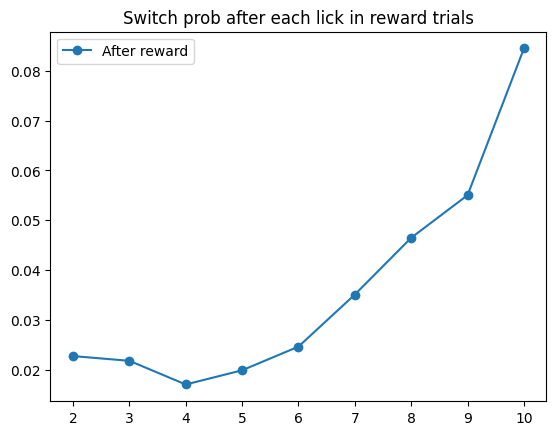

In [770]:
# do the same for reward trials
rwd_trials = session_tbl[(session_tbl['rewarded_historyL'] == 1) | (session_tbl['rewarded_historyR'] == 1)].index.values
rwd_licks_mat = np.full((rwd_trials.shape[0], 10), np.nan)
lick_ind = session_licks_trial['detected_lick_ind'][rwd_trials].values
reward_ind = np.full(rwd_trials.shape[0], np.nan)
# fill in the matrix
for i, trial_ind in enumerate(rwd_trials):
    goCue_start_time = session_tbl.loc[trial_ind, 'goCue_start_time']
    reward_time = session_tbl.loc[trial_ind, 'reward_outcome_time']+0.2
    lick_times = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'start_time'
    ].values
    lick_max_y = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 3),
        'max_y_from_jaw'
    ].values
    lick_sides = [0 if y < center_line else 1 for y in lick_max_y]
    rwd_licks_mat[i, :len(lick_sides)] = lick_sides[:10]
    reward_ind[i] = np.where(lick_times >= reward_time)[0][0] if np.any(lick_times >= reward_time) else np.nan
# compute switch prob for each lick index
# in rwd_licks_mat, compute if each lick is different from the previous one
diff_mat = rwd_licks_mat[:, 1:] != rwd_licks_mat[:, :-1]
switch_probs_rwd = []
switch_probs_rwd = np.nanmean(diff_mat, axis=0)
plt.plot(range(2, 11), switch_probs_rwd, marker='o', label='After reward')
plt.legend()
plt.title('Switch prob after each lick in reward trials')

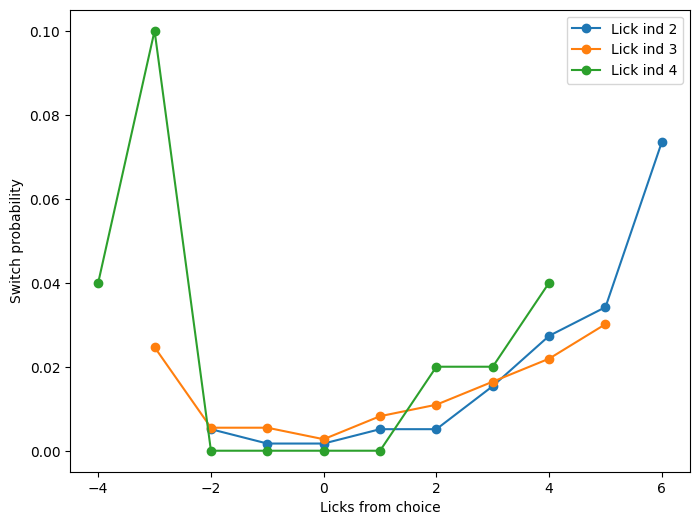

In [771]:
# bin trials by lick_ind 
fig = plt.figure(figsize=(8, 6))
switch_probs_binned = []
for lick_ind_bin in range(2, 5):
    curr_swithes = np.nanmean(diff_mat[reward_ind==lick_ind_bin, :], axis=0)
    switch_probs_binned.append(curr_swithes)
    plt.plot(range(-lick_ind_bin, -lick_ind_bin+curr_swithes.shape[0]), curr_swithes, marker='o', label=f'Lick ind {lick_ind_bin}')
plt.xlabel('Licks from choice')
plt.ylabel('Switch probability')
plt.legend()

Text(0.5, 0, 'Licks from reward')

<Figure size 800x600 with 0 Axes>

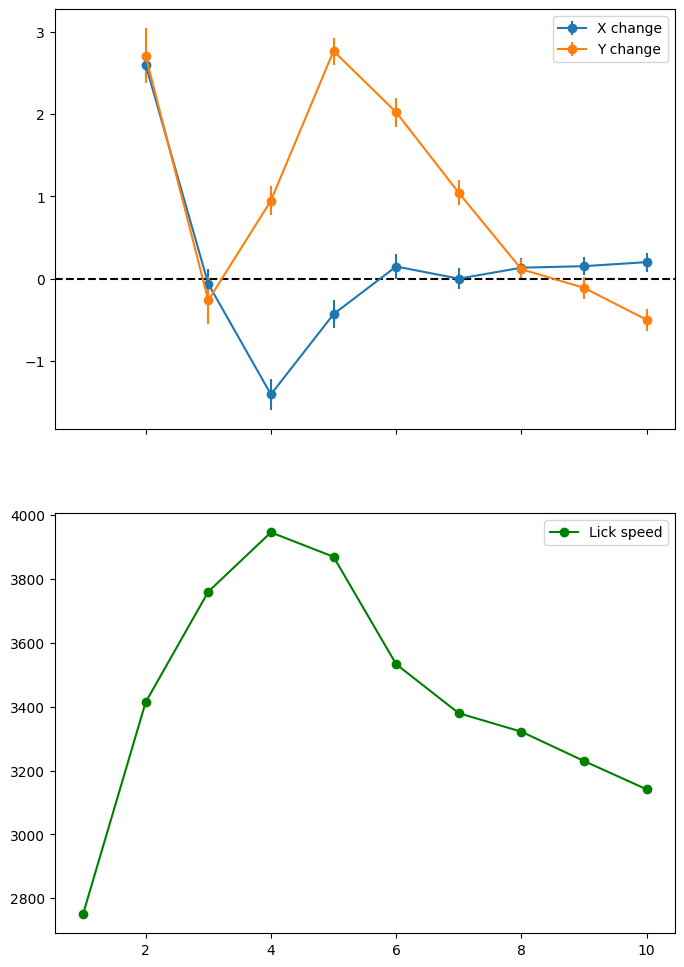

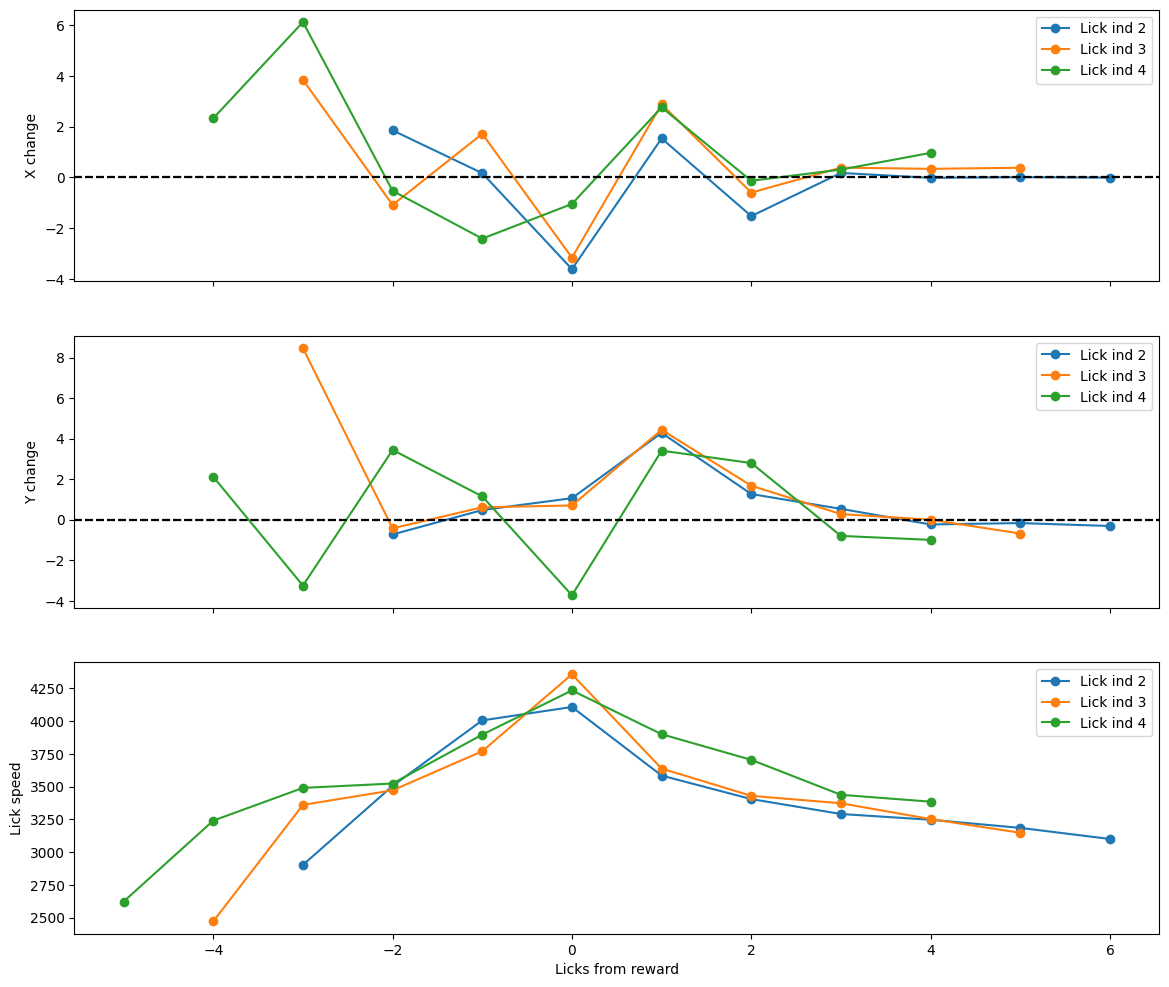

In [772]:
# see correction as location change
# focus on reward trials, see switch prob after each lick
rwd_trials = session_tbl[session_tbl['rewarded_historyL'] | session_tbl['rewarded_historyR']].index.values
rwd_licks_x_mat = np.full((rwd_trials.shape[0], 10), np.nan)
rwd_licks_y_mat = np.full((rwd_trials.shape[0], 10), np.nan)
rwd_licks_speed_mat  = np.full((rwd_trials.shape[0], 10), np.nan)
lick_ind = session_licks_trial['detected_lick_ind'][rwd_trials].values
reward_ind = np.full(rwd_trials.shape[0], np.nan)
# fill in the matrix
for i, trial_ind in enumerate(rwd_trials):
    goCue_start_time = session_tbl.loc[trial_ind, 'goCue_start_time']
    reward_time = session_tbl.loc[trial_ind, 'reward_outcome_time']+0.2
    lick_max_x = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'max_x_from_jaw'
    ].values
    lick_max_y = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 3),
        'max_y_from_jaw'
    ].values
    lick_times = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'start_time'
    ].values
    lick_max_speed = session_licks_df.loc[
        (session_licks_df['start_time'] >= goCue_start_time) &
        (session_licks_df['start_time'] <= goCue_start_time + 2),
        'peak_velocity'
    ].values

    rwd_licks_x_mat[i, :len(lick_max_x)] = lick_max_x[:10]
    rwd_licks_y_mat[i, :len(lick_max_y)] = lick_max_y[:10]
    rwd_licks_speed_mat[i, :len(lick_max_speed)] = lick_max_speed[:10]
    reward_ind[i] = np.where(lick_times >= reward_time)[0][0] if np.any(lick_times >= reward_time) else np.nan
# compute switch prob for each lick index
# in rwd_licks_mat, compute if each lick is different from the previous one
diff_mat_y = (rwd_licks_y_mat[:, 1:]  - rwd_licks_y_mat[:, :-1]) * np.sign((rwd_licks_y_mat[:, 0]-center_line)).reshape(-1, 1)
diff_mat_x = rwd_licks_x_mat[:, 1:]  - rwd_licks_x_mat[:, :-1]
diff_mat_x_mean = np.nanmean(diff_mat_x, axis=0)
diff_mat_y_mean = np.nanmean(diff_mat_y, axis=0)
diff_mat_x_sem = stats.sem(diff_mat_x, axis=0, nan_policy='omit')
diff_mat_y_sem = stats.sem(abs(diff_mat_y), axis=0, nan_policy='omit')
fig = plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
axes[0].errorbar(range(2, 11), diff_mat_x_mean, yerr=diff_mat_x_sem, marker='o', label='X change')
axes[0].errorbar(range(2, 11), diff_mat_y_mean, yerr=diff_mat_y_sem, marker='o', label='Y change')
axes[0].axhline(0, color='k', linestyle='--')
axes[0].legend()
speed_mean = np.nanmean(rwd_licks_speed_mat, axis=0)
axes[1].plot(range(1, 11), speed_mean, marker='o', color='g', label='Lick speed')
axes[1].legend()

# bin trials by lick_ind
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
diff_mat_x_binned = []
diff_mat_y_binned = []
for lick_ind_bin in range(2, 5):
    curr_x_change = np.nanmean((diff_mat_x[reward_ind==lick_ind_bin, :]), axis=0)
    curr_y_change = np.nanmean((diff_mat_y[reward_ind==lick_ind_bin, :]), axis=0)
    curr_speed = np.nanmean((rwd_licks_speed_mat[reward_ind==lick_ind_bin, :]), axis=0)
    diff_mat_x_binned.append(curr_x_change)
    diff_mat_y_binned.append(curr_y_change)
    axes[0].plot(range(-lick_ind_bin, -lick_ind_bin+curr_x_change.shape[0]), curr_x_change, marker='o', label=f'Lick ind {lick_ind_bin}')
    axes[0].axhline(0, color='k', linestyle='--')
    axes[0].legend()
    axes[0].set_ylabel('X change')  
    axes[1].plot(range(-lick_ind_bin, -lick_ind_bin+curr_y_change.shape[0]), curr_y_change, marker='o', label=f'Lick ind {lick_ind_bin}')
    axes[1].axhline(0, color='k', linestyle='--')
    axes[1].set_ylabel('Y change')
    axes[1].legend()
    axes[2].plot(range(-lick_ind_bin-1, -lick_ind_bin+curr_y_change.shape[0]), curr_speed, marker='o', label=f'Lick ind {lick_ind_bin}')
    axes[2].set_ylabel('Lick speed')
    axes[2].legend()
plt.xlabel('Licks from reward')

